# K-Means Clustering - Schweizer Wanderwege

Dieses Notebook führt ein k-means Clustering der Schweizer Wanderwege durch, um ähnliche Wanderrouten zu gruppieren.

**Ziele:**
- Daten aus dem CSV-Dump laden und vorbereiten
- Explorative Datenanalyse für Clustering-Features
- Optimale Anzahl von Clustern bestimmen (Elbow-Methode, Silhouette-Score)
- K-Means Clustering durchführen
- Cluster interpretieren und visualisieren

## 1. Setup & Daten laden

In [34]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from db_utils import read_from_db
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [35]:
# Load data from CSV dump
df = read_from_db("SELECT * FROM wanderwege")

df.head()

Loaded 375 rows, 13 columns from database


,url,title,location,canton,difficulty_level,difficulty_num,duration_min,distance_km,ascent_m,descent_m,physical_demand,latitude,longitude
0,https://www.schweizer-wanderwege.ch/de/wanderv...,Husky-Traum,Muotathal,None,None,NaN,NaN,0.00,NaN,NaN,hoch,46.97,8.77
1,https://www.schweizer-wanderwege.ch/de/wanderv...,Aufregende Ausblicke auf dem Hochalp Trail,"Urnäsch, Anker",AR,None,NaN,405.00,11.40,720.00,720.00,hoch,47.31,9.28
2,https://www.schweizer-wanderwege.ch/de/wanderv...,Den ganzen Tag im Schnee,"Atzmännig SSA — Atzmännig, Schutt",SG,None,NaN,100.00,4.20,140.00,510.00,mittel,NaN,NaN
3,https://www.schweizer-wanderwege.ch/de/wanderv...,Panorama Trail in Obwalden,Langis,OW,None,NaN,270.00,12.30,565.00,565.00,hoch,46.89,8.13
4,https://www.schweizer-wanderwege.ch/de/wanderv...,Schneeschuhwanderung auf den Chasseron,"Les Rasses, village",VD,None,NaN,260.00,10.00,450.00,450.00,hoch,46.83,6.55


## 2. Datenexploration und Vorbereitung

In [36]:
# Überblick über die Datenqualität
print("="*80)
print("DATENQUALITÄT")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"\nData Types:")
print(df.dtypes)
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nPercentage Missing:")
print((df.isnull().sum() / len(df) * 100).round(2))

DATENQUALITÄT

Dataset Shape: (375, 13)

Data Types:
url                  object
title                object
location             object
canton               object
difficulty_level     object
difficulty_num      float64
duration_min        float64
distance_km         float64
ascent_m            float64
descent_m           float64
physical_demand      object
latitude            float64
longitude           float64
dtype: object

Missing Values:
url                   0
title                 0
location              0
canton                3
difficulty_level    274
difficulty_num      274
duration_min          3
distance_km           0
ascent_m              2
descent_m             3
physical_demand       0
latitude             33
longitude            33
dtype: int64

Percentage Missing:
url                 0.00
title               0.00
location            0.00
canton              0.80
difficulty_level   73.07
difficulty_num     73.07
duration_min        0.80
distance_km         0.00
ascent

In [37]:
# Deskriptive Statistiken für numerische Variablen
numeric_cols = ['duration_min', 'distance_km', 'ascent_m', 'descent_m', 'difficulty_num', 'latitude', 'longitude']

print("="*80)
print("DESKRIPTIVE STATISTIKEN")
print("="*80)
desc_stats = df[numeric_cols].describe().T
desc_stats['median'] = df[numeric_cols].median()
desc_stats = desc_stats[['count', 'mean', 'median', 'std', 'min', 'max']]
print(desc_stats)

DESKRIPTIVE STATISTIKEN
                count   mean  median    std   min     max
duration_min   372.00 182.18  175.00  75.10 35.00  435.00
distance_km    375.00   8.72    8.40   3.73  0.00   24.30
ascent_m       373.00 314.03  290.00 187.99  0.00 1080.00
descent_m      372.00 351.10  315.00 221.82  5.00 1310.00
difficulty_num 101.00   1.12    1.00   0.35  1.00    3.00
latitude       342.00  46.97   46.82   1.24 43.04   58.89
longitude      342.00   8.30    8.16   2.08 -4.73   25.57


In [38]:
# Datenbereinigung: Entferne Zeilen mit fehlenden kritischen Werten
df_clean = df.copy()

# Entferne Zeilen wo wichtige Wanderweg-Metriken fehlen oder 0 sind
print(f"Vor Bereinigung: {len(df_clean)} Zeilen")

# Entferne Zeilen mit fehlenden oder ungültigen Koordinaten
df_clean = df_clean[(df_clean['latitude'] != 0) & (df_clean['longitude'] != 0)]
df_clean = df_clean[df_clean['latitude'].notna() & df_clean['longitude'].notna()]

# Entferne Zeilen mit fehlenden Basis-Metriken
df_clean = df_clean[df_clean['duration_min'] > 0]
df_clean = df_clean[df_clean['distance_km'] > 0]

print(f"Nach Bereinigung: {len(df_clean)} Zeilen")
print(f"Entfernt: {len(df) - len(df_clean)} Zeilen ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")

Vor Bereinigung: 375 Zeilen
Nach Bereinigung: 339 Zeilen
Entfernt: 36 Zeilen (9.6%)


## 3. Feature Selection für Clustering

Wir verwenden folgende Features für das Clustering:
- **duration_min**: Dauer der Wanderung in Minuten
- **distance_km**: Distanz in Kilometern
- **ascent_m**: Aufstieg in Metern
- **descent_m**: Abstieg in Metern

Diese Features beschreiben die physischen Eigenschaften der Wanderwege und ermöglichen eine sinnvolle Gruppierung nach Schwierigkeitsgrad und Länge.

In [39]:
# Feature Selection für Clustering
clustering_features = ['duration_min', 'distance_km', 'ascent_m', 'descent_m']

# Erstelle Feature-Matrix
X = df_clean[clustering_features].copy()

print(f"Feature Matrix Shape: {X.shape}")
print(f"\nFeatures für Clustering:")
for i, feature in enumerate(clustering_features, 1):
    print(f"  {i}. {feature}")

print(f"\nFeature Statistics:")
print(X.describe())

Feature Matrix Shape: (339, 4)

Features für Clustering:
  1. duration_min
  2. distance_km
  3. ascent_m
  4. descent_m

Feature Statistics:
       duration_min  distance_km  ascent_m  descent_m
count        339.00       339.00    339.00     339.00
mean         181.24         8.82    313.58     347.65
std           74.35         3.70    187.66     219.66
min           35.00         1.60      5.00      10.00
25%          130.00         5.90    175.00     190.00
50%          175.00         8.40    290.00     315.00
75%          220.00        11.15    417.50     460.00
max          435.00        24.30   1080.00    1310.00


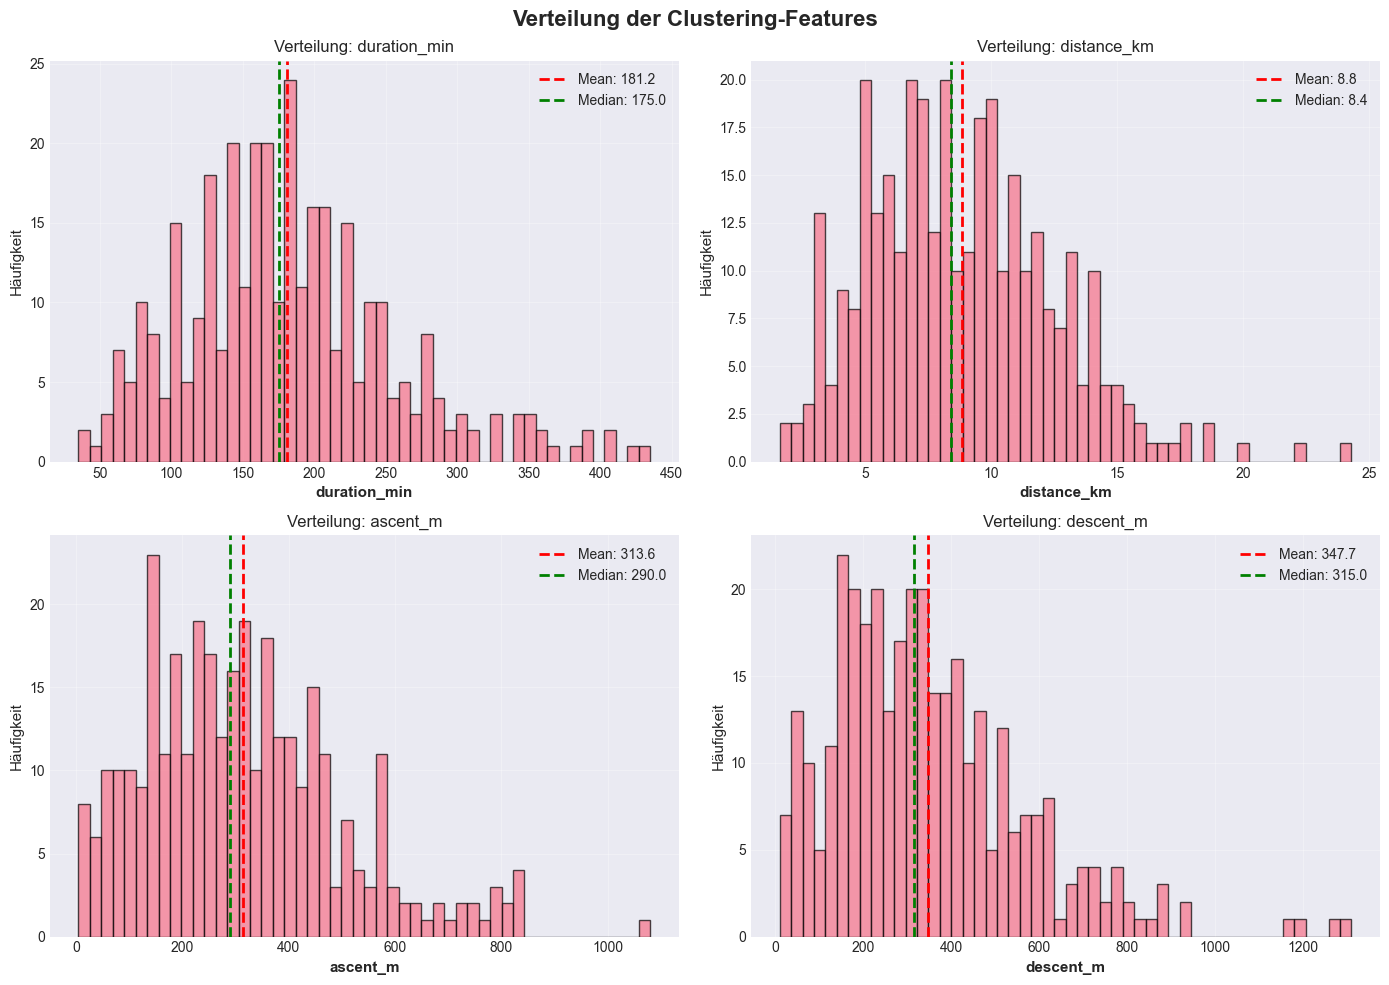

In [40]:
# Visualisierung der Feature-Verteilungen
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Verteilung der Clustering-Features', fontsize=16, fontweight='bold')

for idx, feature in enumerate(clustering_features):
    ax = axes[idx // 2, idx % 2]
    
    # Histogram mit KDE
    X[feature].hist(bins=50, ax=ax, alpha=0.7, edgecolor='black')
    ax.set_xlabel(feature, fontsize=11, fontweight='bold')
    ax.set_ylabel('Häufigkeit', fontsize=11)
    ax.set_title(f'Verteilung: {feature}', fontsize=12)
    
    # Statistiken hinzufügen
    mean_val = X[feature].mean()
    median_val = X[feature].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

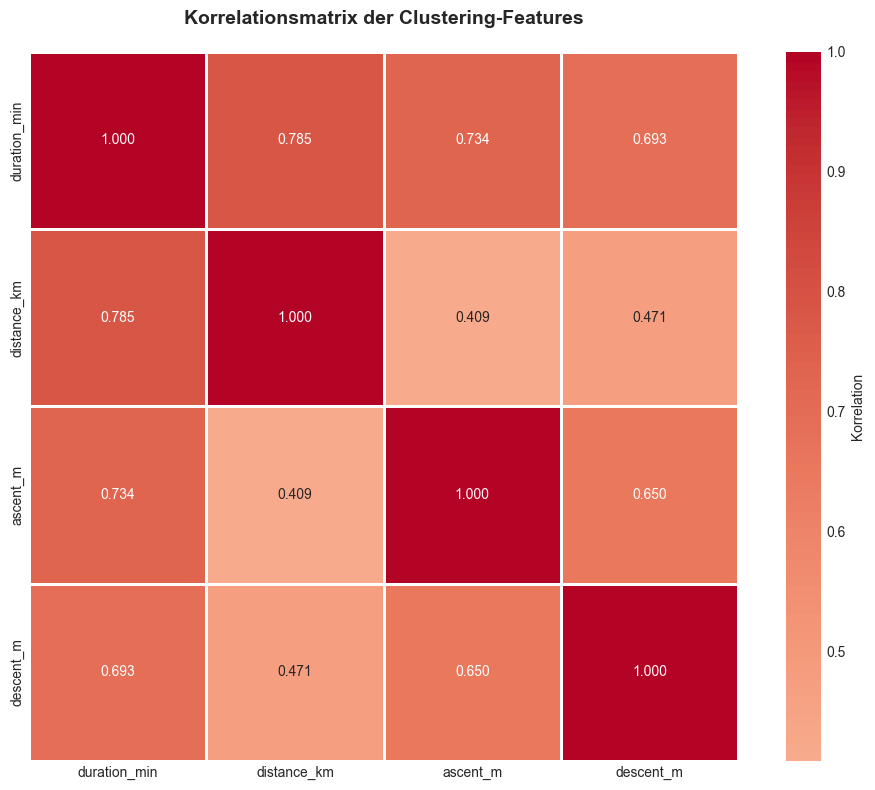


Korrelationsmatrix:
              duration_min  distance_km  ascent_m  descent_m
duration_min          1.00         0.79      0.73       0.69
distance_km           0.79         1.00      0.41       0.47
ascent_m              0.73         0.41      1.00       0.65
descent_m             0.69         0.47      0.65       1.00


In [41]:
# Korrelationsmatrix der Features
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()

sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={'label': 'Korrelation'})

plt.title('Korrelationsmatrix der Clustering-Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKorrelationsmatrix:")
print(correlation_matrix)

## 4. Feature Scaling

K-Means ist distanzbasiert, daher müssen wir die Features standardisieren, damit alle Features gleich gewichtet werden.

In [42]:
# Standardisierung der Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Erstelle DataFrame mit skalierten Daten
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features, index=X.index)

print("="*80)
print("FEATURE SCALING")
print("="*80)
print(f"\nOriginal Features - Statistics:")
print(X.describe().loc[['mean', 'std']])
print(f"\nScaled Features - Statistics (sollte mean≈0, std≈1 sein):")
print(X_scaled_df.describe().loc[['mean', 'std']])

FEATURE SCALING

Original Features - Statistics:
      duration_min  distance_km  ascent_m  descent_m
mean        181.24         8.82    313.58     347.65
std          74.35         3.70    187.66     219.66

Scaled Features - Statistics (sollte mean≈0, std≈1 sein):
      duration_min  distance_km  ascent_m  descent_m
mean          0.00        -0.00     -0.00       0.00
std           1.00         1.00      1.00       1.00


## 5. Optimale Anzahl Cluster bestimmen

Wir verwenden drei Methoden:
1. **Elbow-Methode**: Sucht nach dem "Ellbogen" im Inertia-Plot
2. **Silhouette-Score**: Misst wie gut Datenpunkte zu ihrem Cluster passen
3. **Davies-Bouldin-Score**: Misst die durchschnittliche Ähnlichkeit zwischen Clustern (niedriger ist besser)

In [43]:
# Berechne Metriken für verschiedene k-Werte
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("Berechne Clustering-Metriken für verschiedene k-Werte...")
print("="*80)

for k in k_range:
    # K-Means mit aktuellem k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # Metriken berechnen
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_scaled, labels)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette={silhouette:.3f}, Davies-Bouldin={davies_bouldin:.3f}")

print("="*80)

Berechne Clustering-Metriken für verschiedene k-Werte...
k=2: Inertia=738.41, Silhouette=0.408, Davies-Bouldin=0.962
k=3: Inertia=562.65, Silhouette=0.330, Davies-Bouldin=1.056
k=4: Inertia=469.93, Silhouette=0.276, Davies-Bouldin=1.180
k=5: Inertia=392.93, Silhouette=0.296, Davies-Bouldin=1.060
k=6: Inertia=358.96, Silhouette=0.276, Davies-Bouldin=1.175
k=7: Inertia=319.22, Silhouette=0.296, Davies-Bouldin=1.029
k=8: Inertia=293.65, Silhouette=0.282, Davies-Bouldin=1.065
k=9: Inertia=271.26, Silhouette=0.295, Davies-Bouldin=0.992
k=10: Inertia=248.28, Silhouette=0.314, Davies-Bouldin=1.028


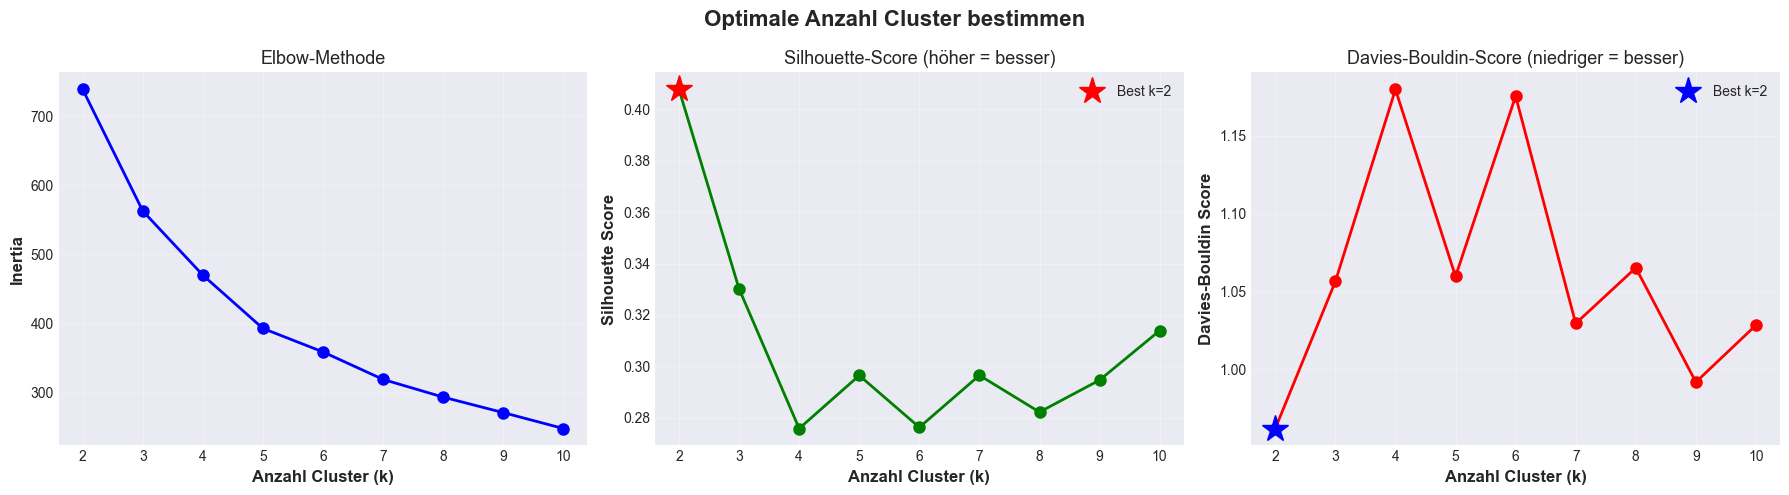

In [44]:
# Visualisierung der Metriken
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Optimale Anzahl Cluster bestimmen', fontsize=16, fontweight='bold')

# 1. Elbow-Methode (Inertia)
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Anzahl Cluster (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow-Methode', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# 2. Silhouette-Score
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Anzahl Cluster (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette-Score (höher = besser)', fontsize=13)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# Markiere Maximum
max_idx = np.argmax(silhouette_scores)
axes[1].plot(list(k_range)[max_idx], silhouette_scores[max_idx], 'r*', markersize=20, label=f'Best k={list(k_range)[max_idx]}')
axes[1].legend()

# 3. Davies-Bouldin-Score
axes[2].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Anzahl Cluster (k)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12, fontweight='bold')
axes[2].set_title('Davies-Bouldin-Score (niedriger = besser)', fontsize=13)
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)

# Markiere Minimum
min_idx = np.argmin(davies_bouldin_scores)
axes[2].plot(list(k_range)[min_idx], davies_bouldin_scores[min_idx], 'b*', markersize=20, label=f'Best k={list(k_range)[min_idx]}')
axes[2].legend()

plt.tight_layout()
plt.show()

In [45]:
# Empfehlung basierend auf den Metriken
best_k_silhouette = list(k_range)[np.argmax(silhouette_scores)]
best_k_davies = list(k_range)[np.argmin(davies_bouldin_scores)]

print("="*80)
print("EMPFEHLUNG FÜR OPTIMALES k")
print("="*80)
print(f"\nBasierend auf Silhouette-Score: k = {best_k_silhouette}")
print(f"Basierend auf Davies-Bouldin-Score: k = {best_k_davies}")
print(f"\nElbow-Methode: Visuell interpretieren (typischerweise k = 3-5)")
print(f"\n→ Empfehlung: k = {best_k_silhouette} (basierend auf höchstem Silhouette-Score)")
print("="*80)

EMPFEHLUNG FÜR OPTIMALES k

Basierend auf Silhouette-Score: k = 2
Basierend auf Davies-Bouldin-Score: k = 2

Elbow-Methode: Visuell interpretieren (typischerweise k = 3-5)

→ Empfehlung: k = 2 (basierend auf höchstem Silhouette-Score)


## 6. K-Means Clustering mit optimaler Cluster-Anzahl

In [46]:
# Wähle optimales k (kann hier angepasst werden)
optimal_k = best_k_silhouette

print(f"Führe K-Means Clustering mit k = {optimal_k} durch...\n")

# K-Means mit optimalem k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_clean['cluster'] = kmeans_final.fit_predict(X_scaled)

# Cluster-Statistiken
print("="*80)
print(f"K-MEANS CLUSTERING RESULTS (k = {optimal_k})")
print("="*80)
print(f"\nCluster-Verteilung:")
print(df_clean['cluster'].value_counts().sort_index())
print(f"\nCluster-Größen (Prozent):")
print((df_clean['cluster'].value_counts(normalize=True).sort_index() * 100).round(2))

Führe K-Means Clustering mit k = 2 durch...

K-MEANS CLUSTERING RESULTS (k = 2)

Cluster-Verteilung:
cluster
0    218
1    121
Name: count, dtype: int64

Cluster-Größen (Prozent):
cluster
0   64.31
1   35.69
Name: proportion, dtype: float64



CLUSTER-ZENTROIDEN (Original-Skala)
           duration_min  distance_km  ascent_m  descent_m
Cluster 0        139.47         7.00    224.13     244.17
Cluster 1        256.49        12.11    474.75     534.09


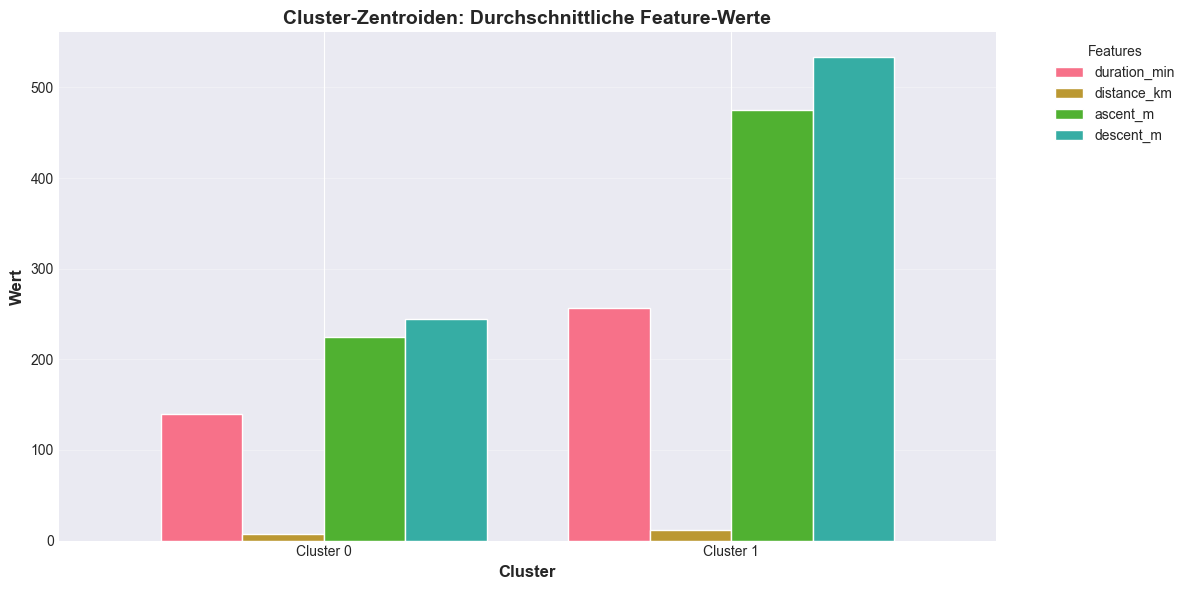

In [47]:
# Cluster-Zentroiden (zurücktransformiert auf Original-Skala)
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids_original, columns=clustering_features)
centroids_df.index = [f'Cluster {i}' for i in range(optimal_k)]

print("\n" + "="*80)
print("CLUSTER-ZENTROIDEN (Original-Skala)")
print("="*80)
print(centroids_df)

# Visualisierung der Zentroiden
fig, ax = plt.subplots(figsize=(12, 6))
centroids_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Cluster-Zentroiden: Durchschnittliche Feature-Werte', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Wert', fontsize=12, fontweight='bold')
ax.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Cluster-Charakterisierung

Analysieren wir die Eigenschaften der einzelnen Cluster im Detail.

In [48]:
# Detaillierte Cluster-Statistiken
print("="*80)
print("DETAILLIERTE CLUSTER-CHARAKTERISIERUNG")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} - {len(cluster_data)} Wanderwege ({len(cluster_data)/len(df_clean)*100:.1f}%)")
    print(f"{'='*80}")
    
    # Statistiken für numerische Features
    cluster_stats = cluster_data[clustering_features].describe().T
    cluster_stats['median'] = cluster_data[clustering_features].median()
    cluster_stats = cluster_stats[['mean', 'median', 'min', 'max']]
    print(cluster_stats)
    
    # Häufigste Schwierigkeitsgrade
    if 'physical_demand' in cluster_data.columns:
        print(f"\nPhysische Anforderung:")
        print(cluster_data['physical_demand'].value_counts().head())
    
    # Häufigste Kantone
    if 'canton' in cluster_data.columns:
        top_cantons = cluster_data['canton'].value_counts().head(5)
        if len(top_cantons) > 0:
            print(f"\nTop 5 Kantone:")
            print(top_cantons)

DETAILLIERTE CLUSTER-CHARAKTERISIERUNG

CLUSTER 0 - 218 Wanderwege (64.3%)
               mean  median   min    max
duration_min 139.47  145.00 35.00 230.00
distance_km    7.00    6.90  1.60  14.90
ascent_m     224.13  217.50  5.00 740.00
descent_m    244.17  225.00 10.00 850.00

Physische Anforderung:
physical_demand
mittel    123
tief       72
hoch       23
Name: count, dtype: int64

Top 5 Kantone:
canton
BE    43
VS    28
GR    25
VD    16
TI    12
Name: count, dtype: int64

CLUSTER 1 - 121 Wanderwege (35.7%)
               mean  median    min     max
duration_min 256.49  240.00 170.00  435.00
distance_km   12.11   11.70   5.60   24.30
ascent_m     474.75  455.00  20.00 1080.00
descent_m    534.09  515.00  50.00 1310.00

Physische Anforderung:
physical_demand
hoch      77
mittel    44
Name: count, dtype: int64

Top 5 Kantone:
canton
GR    19
BE    15
VS    15
TI    12
VD     6
Name: count, dtype: int64


In [49]:
# Cluster-Labels basierend auf Charakteristiken erstellen
cluster_labels = {}

for cluster_id in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    avg_duration = cluster_data['duration_min'].mean()
    avg_distance = cluster_data['distance_km'].mean()
    avg_ascent = cluster_data['ascent_m'].mean()
    
    # Erstelle beschreibenden Label
    if avg_duration < 120 and avg_distance < 5:
        label = "Kurze Wanderungen"
    elif avg_duration < 240 and avg_distance < 10:
        label = "Mittlere Wanderungen"
    elif avg_ascent > 800:
        label = "Bergtouren (hoher Aufstieg)"
    elif avg_distance > 15:
        label = "Lange Distanzen"
    else:
        label = "Herausfordernde Touren"
    
    cluster_labels[cluster_id] = label

print("\n" + "="*80)
print("CLUSTER-LABELS")
print("="*80)
for cluster_id, label in cluster_labels.items():
    count = len(df_clean[df_clean['cluster'] == cluster_id])
    print(f"Cluster {cluster_id}: {label} ({count} Wanderwege)")


CLUSTER-LABELS
Cluster 0: Mittlere Wanderungen (218 Wanderwege)
Cluster 1: Herausfordernde Touren (121 Wanderwege)


## 8. Visualisierungen der Cluster

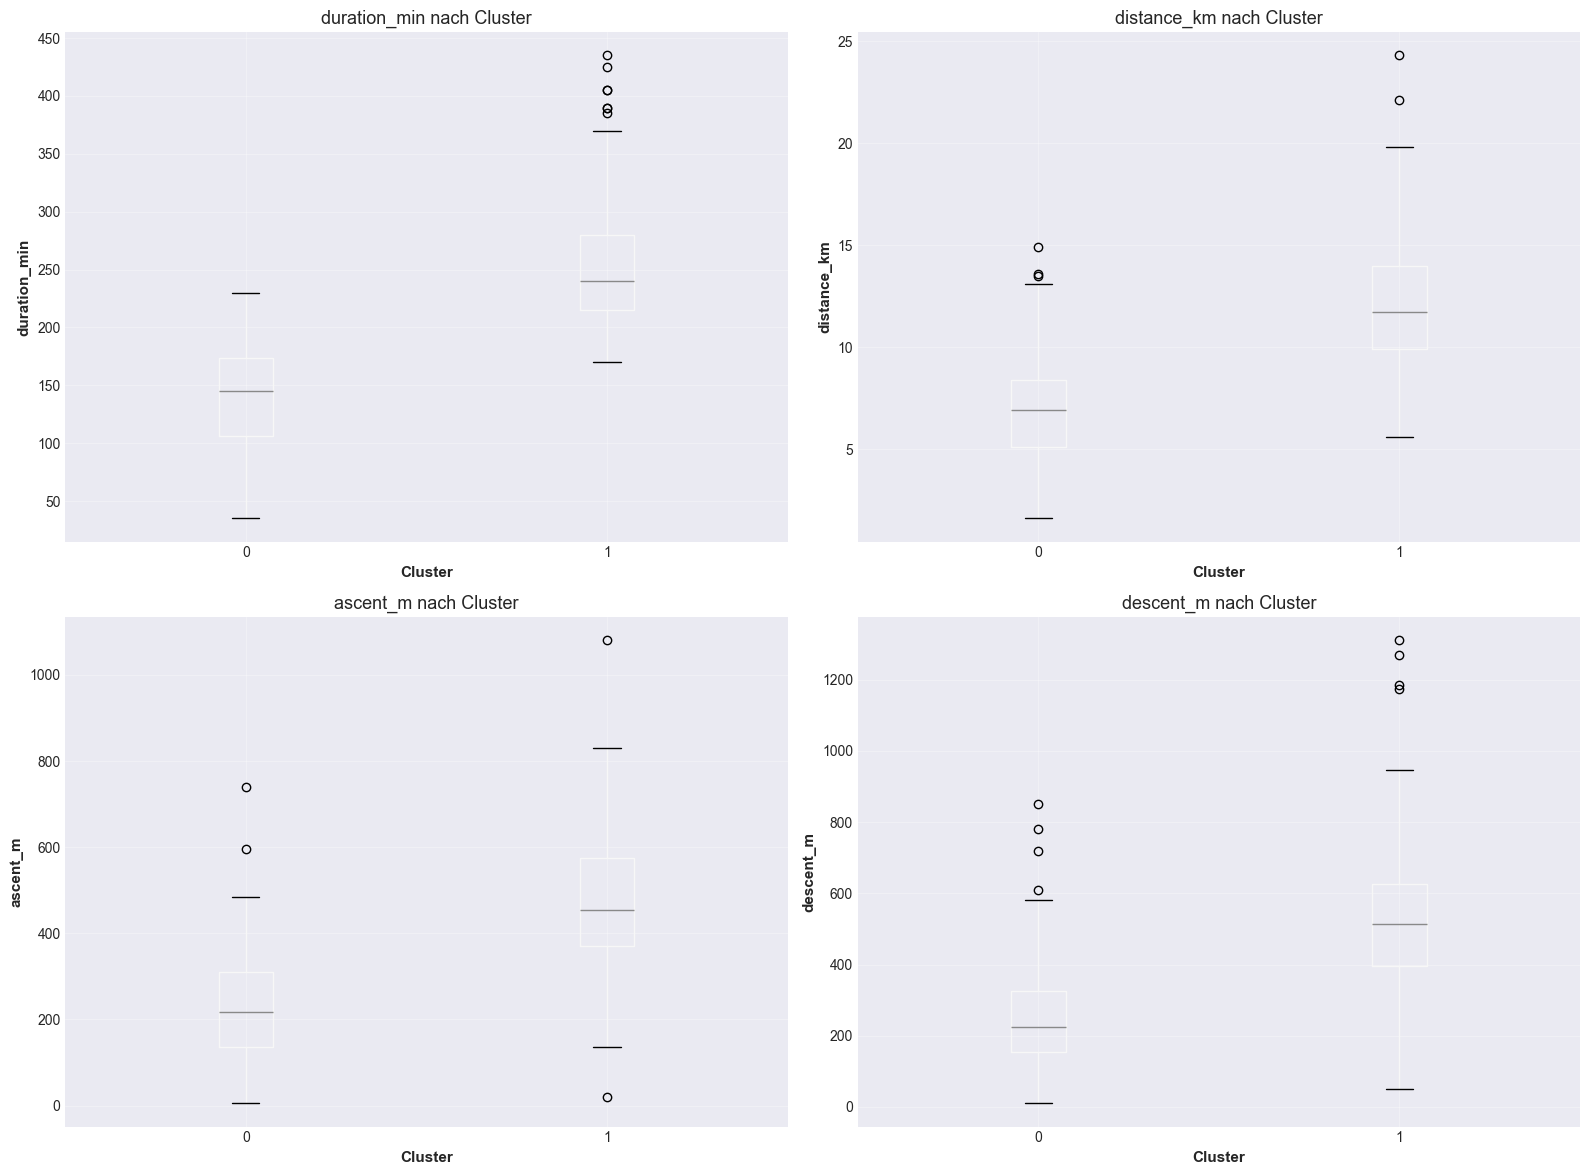

In [50]:
# Boxplots für jedes Feature nach Cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature-Verteilung nach Cluster', fontsize=16, fontweight='bold')

for idx, feature in enumerate(clustering_features):
    ax = axes[idx // 2, idx % 2]
    
    df_clean.boxplot(column=feature, by='cluster', ax=ax)
    ax.set_title(f'{feature} nach Cluster', fontsize=13)
    ax.set_xlabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_ylabel(feature, fontsize=11, fontweight='bold')
    ax.get_figure().suptitle('')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

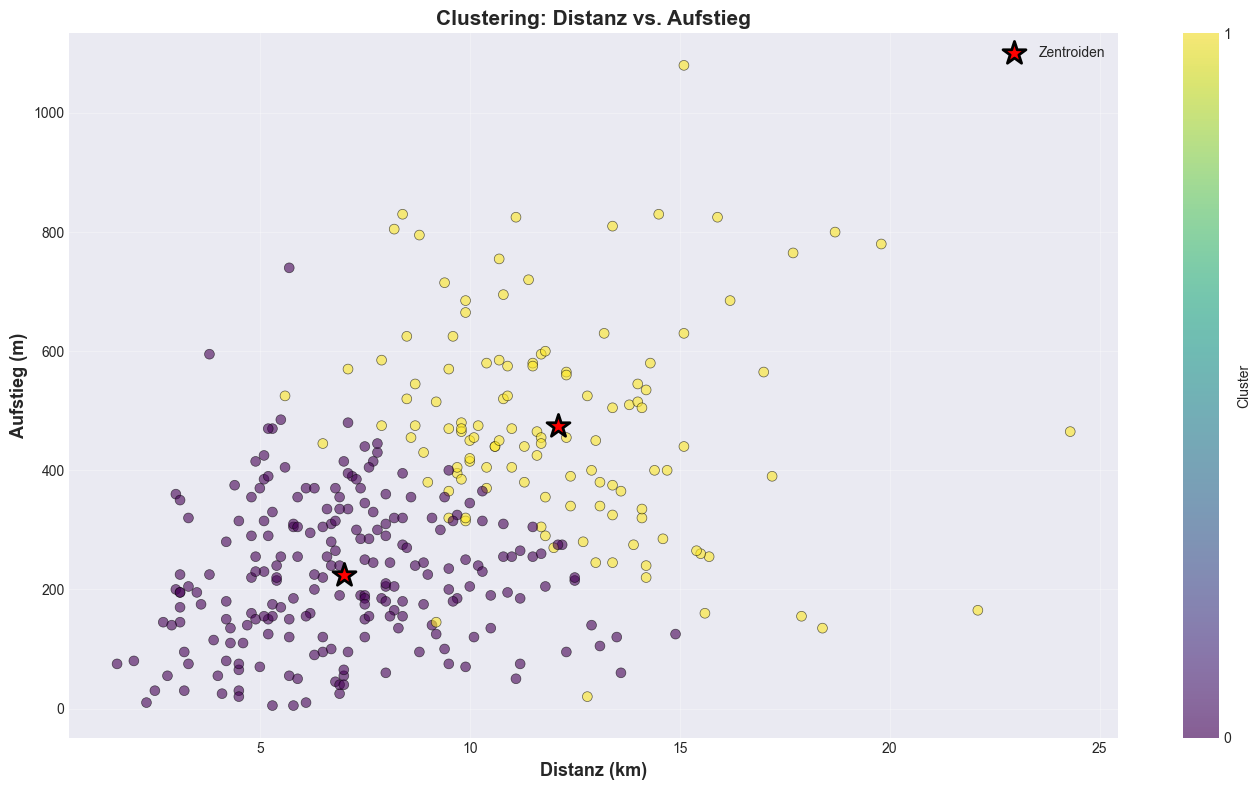

In [51]:
# Scatter-Plot: Distanz vs. Aufstieg, gefärbt nach Cluster
plt.figure(figsize=(14, 8))

scatter = plt.scatter(df_clean['distance_km'], 
                     df_clean['ascent_m'],
                     c=df_clean['cluster'],
                     cmap='viridis',
                     s=50,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

plt.xlabel('Distanz (km)', fontsize=13, fontweight='bold')
plt.ylabel('Aufstieg (m)', fontsize=13, fontweight='bold')
plt.title('Clustering: Distanz vs. Aufstieg', fontsize=15, fontweight='bold')
plt.colorbar(scatter, label='Cluster', ticks=range(optimal_k))
plt.grid(True, alpha=0.3)

# Cluster-Zentroiden hinzufügen
plt.scatter(centroids_df['distance_km'], 
           centroids_df['ascent_m'],
           c='red',
           s=300,
           marker='*',
           edgecolors='black',
           linewidth=2,
           label='Zentroiden')

plt.legend()
plt.tight_layout()
plt.show()

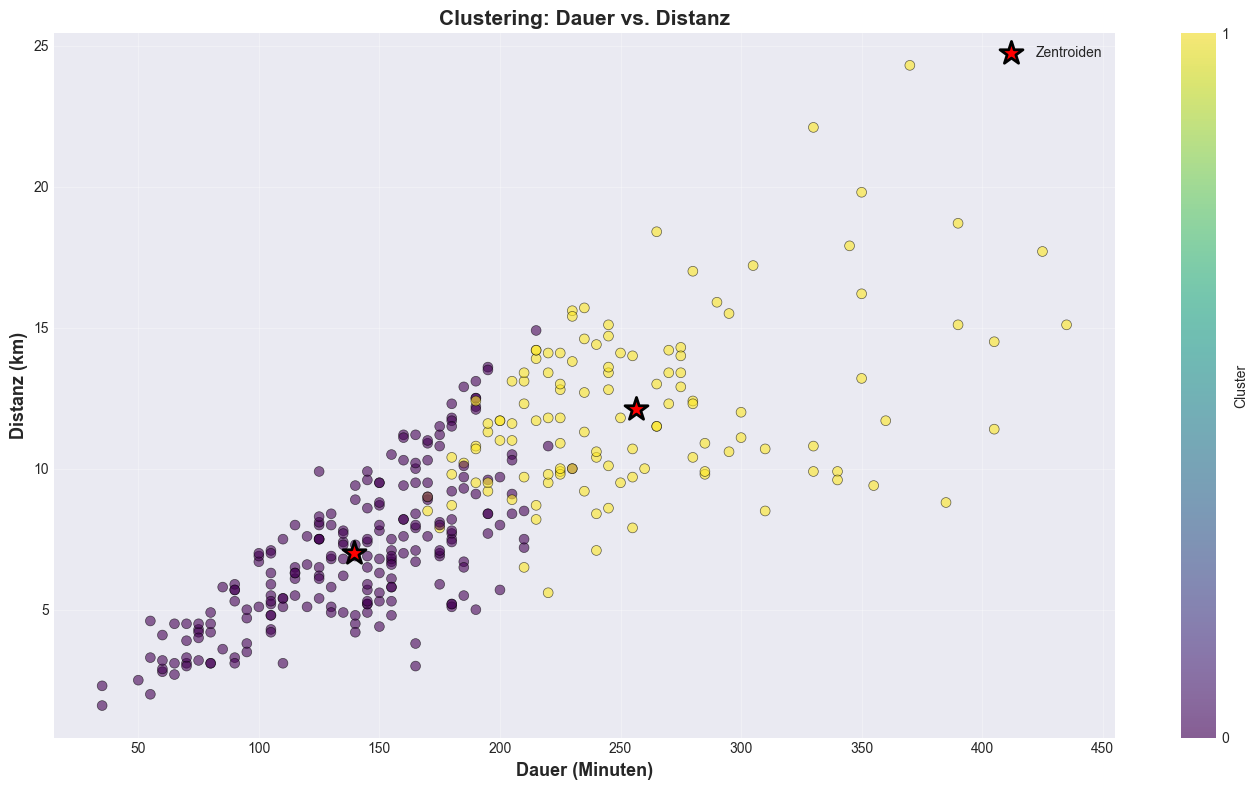

In [52]:
# Scatter-Plot: Dauer vs. Distanz, gefärbt nach Cluster
plt.figure(figsize=(14, 8))

scatter = plt.scatter(df_clean['duration_min'], 
                     df_clean['distance_km'],
                     c=df_clean['cluster'],
                     cmap='viridis',
                     s=50,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

plt.xlabel('Dauer (Minuten)', fontsize=13, fontweight='bold')
plt.ylabel('Distanz (km)', fontsize=13, fontweight='bold')
plt.title('Clustering: Dauer vs. Distanz', fontsize=15, fontweight='bold')
plt.colorbar(scatter, label='Cluster', ticks=range(optimal_k))
plt.grid(True, alpha=0.3)

# Cluster-Zentroiden hinzufügen
plt.scatter(centroids_df['duration_min'], 
           centroids_df['distance_km'],
           c='red',
           s=300,
           marker='*',
           edgecolors='black',
           linewidth=2,
           label='Zentroiden')

plt.legend()
plt.tight_layout()
plt.show()

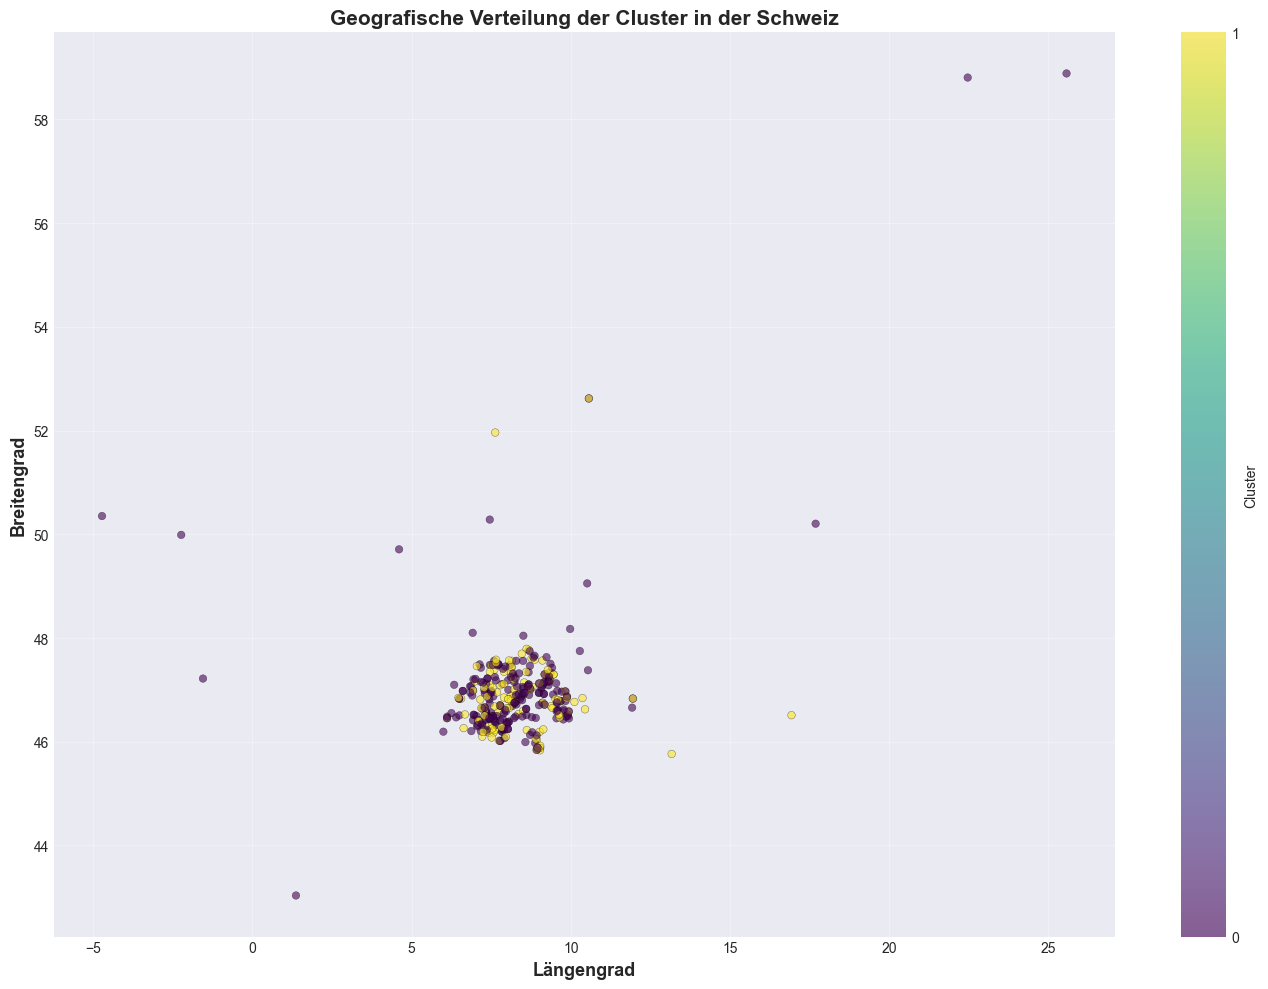

In [53]:
# Geografische Verteilung der Cluster (falls Koordinaten vorhanden)
if 'latitude' in df_clean.columns and 'longitude' in df_clean.columns:
    plt.figure(figsize=(14, 10))
    
    scatter = plt.scatter(df_clean['longitude'], 
                         df_clean['latitude'],
                         c=df_clean['cluster'],
                         cmap='viridis',
                         s=30,
                         alpha=0.6,
                         edgecolors='black',
                         linewidth=0.3)
    
    plt.xlabel('Längengrad', fontsize=13, fontweight='bold')
    plt.ylabel('Breitengrad', fontsize=13, fontweight='bold')
    plt.title('Geografische Verteilung der Cluster in der Schweiz', fontsize=15, fontweight='bold')
    plt.colorbar(scatter, label='Cluster', ticks=range(optimal_k))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

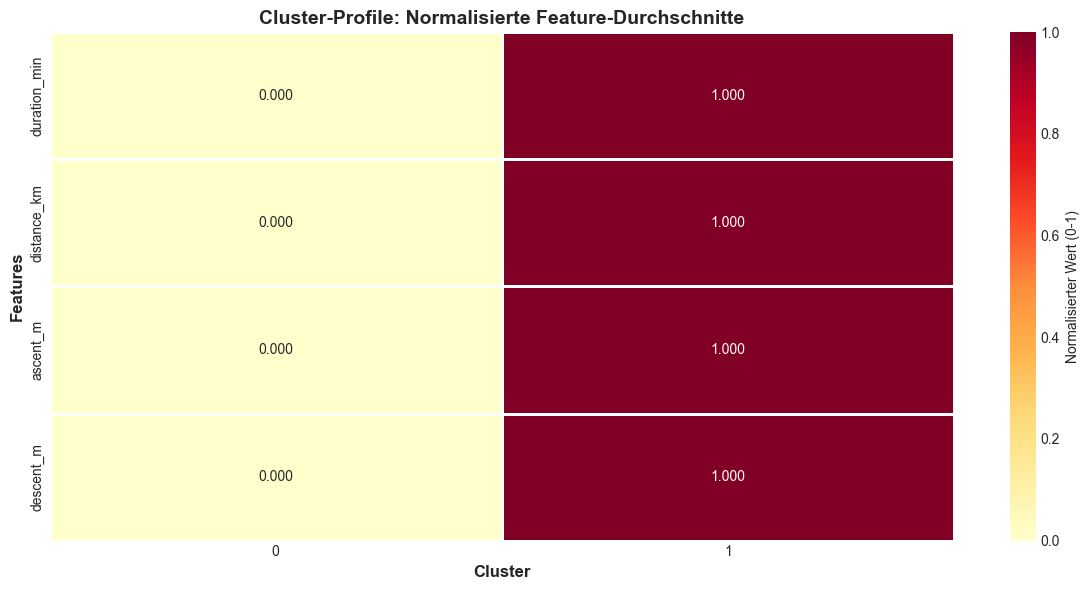

In [54]:
# Heatmap: Durchschnittliche Feature-Werte pro Cluster (normalisiert)
cluster_means = df_clean.groupby('cluster')[clustering_features].mean()

# Normalisiere für bessere Visualisierung
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
cluster_means_norm = pd.DataFrame(
    scaler_viz.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means_norm.T, 
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Normalisierter Wert (0-1)'},
            linewidths=1,
            linecolor='white')

plt.title('Cluster-Profile: Normalisierte Feature-Durchschnitte', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Cluster-Evaluation

In [55]:
# Finale Evaluation-Metriken
final_silhouette = silhouette_score(X_scaled, df_clean['cluster'])
final_davies_bouldin = davies_bouldin_score(X_scaled, df_clean['cluster'])
final_inertia = kmeans_final.inertia_

print("="*80)
print("FINALE CLUSTER-EVALUATION")
print("="*80)
print(f"\nAnzahl Cluster: {optimal_k}")
print(f"Anzahl Datenpunkte: {len(df_clean)}")
print(f"\nQualitäts-Metriken:")
print(f"  - Silhouette Score: {final_silhouette:.4f} (Bereich: -1 bis 1, höher = besser)")
print(f"  - Davies-Bouldin Score: {final_davies_bouldin:.4f} (niedriger = besser)")
print(f"  - Inertia: {final_inertia:.2f}")

# Interpretation
print(f"\nInterpretation:")
if final_silhouette > 0.5:
    print("  ✓ Silhouette Score > 0.5: Gute Cluster-Separation")
elif final_silhouette > 0.25:
    print("  ~ Silhouette Score 0.25-0.5: Akzeptable Cluster-Struktur")
else:
    print("  ✗ Silhouette Score < 0.25: Schwache Cluster-Struktur")

if final_davies_bouldin < 1.0:
    print("  ✓ Davies-Bouldin Score < 1.0: Sehr gute Cluster-Trennung")
elif final_davies_bouldin < 2.0:
    print("  ~ Davies-Bouldin Score 1.0-2.0: Gute Cluster-Trennung")
else:
    print("  ✗ Davies-Bouldin Score > 2.0: Cluster überlappen stark")

print("="*80)

FINALE CLUSTER-EVALUATION

Anzahl Cluster: 2
Anzahl Datenpunkte: 339

Qualitäts-Metriken:
  - Silhouette Score: 0.4078 (Bereich: -1 bis 1, höher = besser)
  - Davies-Bouldin Score: 0.9620 (niedriger = besser)
  - Inertia: 738.41

Interpretation:
  ~ Silhouette Score 0.25-0.5: Akzeptable Cluster-Struktur
  ✓ Davies-Bouldin Score < 1.0: Sehr gute Cluster-Trennung


## 10. Daten speichern

In [56]:
# Speichere geclusterte Daten
output_file = 'schweizer_wanderwege_clustered.csv'
df_clean.to_csv(output_file, sep=';', index=False)

print(f"✓ Geclusterte Daten gespeichert in: {output_file}")
print(f"  - {len(df_clean)} Zeilen")
print(f"  - {optimal_k} Cluster")
print(f"  - Spalten: {df_clean.columns.tolist()}")

✓ Geclusterte Daten gespeichert in: schweizer_wanderwege_clustered.csv
  - 339 Zeilen
  - 2 Cluster
  - Spalten: ['url', 'title', 'location', 'canton', 'difficulty_level', 'difficulty_num', 'duration_min', 'distance_km', 'ascent_m', 'descent_m', 'physical_demand', 'latitude', 'longitude', 'cluster']


## 11. Zusammenfassung und Interpretation

### Cluster-Beschreibungen

Die K-Means Analyse hat die Schweizer Wanderwege in Gruppen mit ähnlichen Eigenschaften unterteilt:

**Verwendete Features:**
- Dauer (Minuten)
- Distanz (Kilometer)
- Aufstieg (Meter)
- Abstieg (Meter)

**Anwendungsfälle:**
1. **Empfehlungssystem**: Wanderer können ähnliche Routen basierend auf ihren Präferenzen finden
2. **Routenplanung**: Identifikation von Wanderwegen mit ähnlichen Schwierigkeitsgraden
3. **Analyse-Tool**: Verstehen der Verteilung und Charakteristiken der Schweizer Wanderwege

**Nächste Schritte:**
- Zusätzliche Features einbeziehen (z.B. Höhenlage, Jahreszeit)
- Alternative Clustering-Methoden testen (DBSCAN, Hierarchisches Clustering)
- Geografische Cluster-Muster analysieren

In [57]:
# Beispiele aus jedem Cluster anzeigen
print("="*80)
print("BEISPIEL-WANDERWEGE AUS JEDEM CLUSTER")
print("="*80)

for cluster_id in range(optimal_k):
    print(f"\n{'='*80}")
    print(f"Cluster {cluster_id}: {cluster_labels.get(cluster_id, f'Cluster {cluster_id}')}")
    print(f"{'='*80}")
    
    cluster_samples = df_clean[df_clean['cluster'] == cluster_id].head(3)
    
    display_cols = ['title', 'location', 'canton', 'duration_min', 'distance_km', 'ascent_m', 'descent_m']
    available_cols = [col for col in display_cols if col in cluster_samples.columns]
    
    print(cluster_samples[available_cols].to_string(index=False))

print("\n" + "="*80)

BEISPIEL-WANDERWEGE AUS JEDEM CLUSTER

Cluster 0: Mittlere Wanderungen
                                                   title                                        location canton  duration_min  distance_km  ascent_m  descent_m
Schneeschuhwandern im freiburgischen Wintersportparadies                        Les Paccots, Les Rosalys     FR        210.00         7.20    390.00     390.00
      Panoramawanderung über verschneite Hochmoorflächen   Zweisimmen, Sparenmoos — Zweisimmen, Site Alp     BE        105.00         4.80    160.00     275.00
                        Auf Walserpfaden durch Obersaxen Obersaxen, Meierhof Post — Obersaxen, Friggahüs     GR        155.00         7.10    335.00     300.00

Cluster 1: Herausfordernde Touren
                                     title            location canton  duration_min  distance_km  ascent_m  descent_m
Aufregende Ausblicke auf dem Hochalp Trail      Urnäsch, Anker     AR        405.00        11.40    720.00     720.00
                Pa